In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Стиль для графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Загружаем данные
df = pd.read_excel('Обращения.xlsx')
print(f"Загружено {len(df)} записей")

df.head()

Загружено 2553 записей


,Дата обращения,Описание,Тема обращения,Идентификатор устройства
0,2025-10-10T07:52:33+03:00[Europe/Moscow],Здравствуйте! Квартира по адресу: Ул. Гризодуб...,Запрос портала,177045
1,2025-09-22T10:47:27+03:00[Europe/Moscow],"По адресу Стрелецкая улица, дом 9, корпус 2 пр...",Запрос портала,86874
2,2025-09-05T17:44:29+03:00[Europe/Moscow],Не могут открыть дверь через приложение . Со с...,Приложение. Умные решения,11699
3,2025-09-06T12:55:35+03:00[Europe/Moscow],Вадим хочет установить в квартире по адресу: <...,Приложение. Умные решения,51120
4,2025-10-17T08:09:09+03:00[Europe/Moscow],Не могу подключить управление домофона чтобы у...,Запрос портала,179157


In [2]:
df.describe()

for i, col in enumerate(df.columns, 1):
    dtype = str(df[col].dtype)
    null_count = df[col].isna().sum()
    null_percent = (null_count / len(df)) * 100
    unique_count = df[col].nunique()

    print(f"{i:2}. {col:30} Тип: {dtype:10} "
          f"Пропуски: {null_count:4} ({null_percent:5.1f}%) "
          f"Уникальных: {unique_count:5}")

 1. Дата обращения                 Тип: object     Пропуски:    0 (  0.0%) Уникальных:  2550
 2. Описание                       Тип: object     Пропуски:    1 (  0.0%) Уникальных:  2545
 3. Тема обращения                 Тип: object     Пропуски:    0 (  0.0%) Уникальных:    45
 4. Идентификатор устройства       Тип: object     Пропуски:    0 (  0.0%) Уникальных:  2063


In [3]:
print("АНАЛИЗ КОЛОНКИ 'ОПИСАНИЕ'")
description_col = 'Описание'

# Статистика по длине текста
df['description_length'] = df[description_col].astype(str).apply(len)
df['word_count'] = df[description_col].astype(str).apply(lambda x: len(str(x).split()))

print("\nСТАТИСТИКА ДЛИНЫ ТЕКСТА:")
print(f"• Средняя длина: {df['description_length'].mean():.0f} символов")
print(f"• Среднее количество слов: {df['word_count'].mean():.1f}")
print(f"• Минимальная длина: {df['description_length'].min()} символов")
print(f"• Максимальная длина: {df['description_length'].max()} символов")
print(f"• Медиана: {df['description_length'].median():.0f} символов")

# Распределение по длине
length_stats = df['description_length'].describe()
print("\nРАСПРЕДЕЛЕНИЕ ПО ДЛИНЕ:")
print(f"• 25% перцентиль: {length_stats['25%']:.0f} символов (короткие)")
print(f"• 50% перцентиль: {length_stats['50%']:.0f} символов (средние)")
print(f"• 75% перцентиль: {length_stats['75%']:.0f} символов (длинные)")

def categorize_length(length):
    """Категоризация по длине текста"""
    if length < 50:
        return 'Очень короткие (<50)'
    elif length < 100:
        return 'Короткие (50-100)'
    elif length < 300:
        return 'Средние (100-300)'
    elif length < 500:
        return 'Длинные (300-500)'
    else:
        return 'Очень длинные (>500)'

df['length_category'] = df['description_length'].apply(categorize_length)

print("\nКАТЕГОРИИ ПО ДЛИНЕ:")
length_counts = df['length_category'].value_counts()
for category, count in length_counts.items():
    percent = (count / len(df)) * 100
    print(f"• {category:25} {count:5} ({percent:5.1f}%)")

АНАЛИЗ КОЛОНКИ 'ОПИСАНИЕ'

СТАТИСТИКА ДЛИНЫ ТЕКСТА:
• Средняя длина: 166 символов
• Среднее количество слов: 24.3
• Минимальная длина: 3 символов
• Максимальная длина: 2000 символов
• Медиана: 122 символов

РАСПРЕДЕЛЕНИЕ ПО ДЛИНЕ:
• 25% перцентиль: 74 символов (короткие)
• 50% перцентиль: 122 символов (средние)
• 75% перцентиль: 196 символов (длинные)

КАТЕГОРИИ ПО ДЛИНЕ:
• Средние (100-300)          1267 ( 49.6%)
• Короткие (50-100)           698 ( 27.3%)
• Очень короткие (<50)        301 ( 11.8%)
• Длинные (300-500)           191 (  7.5%)
• Очень длинные (>500)         96 (  3.8%)


In [4]:
print("АНАЛИЗ КОЛОНКИ 'ТЕМА ОБРАЩЕНИЯ'")

if 'Тема обращения' in df.columns:
    topic_col = 'Тема обращения'

    print(f"\nВСЕГО УНИКАЛЬНЫХ ТЕМ: {df[topic_col].nunique()}")
    print(f"ЗАПОЛНЕННЫХ ТЕМ: {df[topic_col].notna().sum()} ({df[topic_col].notna().sum()/len(df)*100:.1f}%)")

    # Топ-10 тем (вместо 20 для наглядности)
    print("\nТОП-10 ТЕМ ОБРАЩЕНИЙ:")
    topic_counts = df[topic_col].value_counts().head(10)

    for i, (topic, count) in enumerate(topic_counts.items(), 1):
        percent = (count / len(df)) * 100
        print(f"{i:2}. {str(topic)[:50]:50} {count:5} ({percent:6.2f}%)")

АНАЛИЗ КОЛОНКИ 'ТЕМА ОБРАЩЕНИЯ'

ВСЕГО УНИКАЛЬНЫХ ТЕМ: 45
ЗАПОЛНЕННЫХ ТЕМ: 2553 (100.0%)

ТОП-10 ТЕМ ОБРАЩЕНИЙ:
 1. Запрос портала                                      2385 ( 93.42%)
 2. Приложение. Умные решения                            107 (  4.19%)
 3. Общие вопросы оказания ГУ                              9 (  0.35%)
 4. (no subject)                                           5 (  0.20%)
 5. ЕПД / Оплата                                           3 (  0.12%)
 6. Запрос контактных данных администратора ОСС            2 (  0.08%)
 7. Не открывается протокол ОСС в приложении               2 (  0.08%)
 8. Технические ошибки                                     2 (  0.08%)
 9. Дом                                                    2 (  0.08%)
10. Формирование документов для ОСС, домофон iCityPro      1 (  0.04%)


In [5]:
print("АНАЛИЗ КОЛОНКИ 'ДАТА ОБРАЩЕНИЯ'")

if 'Дата обращения' in df.columns:
    date_col = 'Дата обращения'

    print("\nПЕРВЫЕ 5 ЗАПИСЕЙ В КОЛОНКЕ 'Дата обращения':")
    for i, date_str in enumerate(df[date_col].head().tolist(), 1):
        print(f"{i}. {date_str}")

    try:
        # ИСПРАВЛЕННЫЙ ПАРСИНГ ДАТ
        # Убираем временную зону в квадратных скобках и лишние символы
        df['date_clean'] = df[date_col].astype(str).str.split('[').str[0]

        # Пробуем разные форматы парсинга
        df['date_parsed'] = pd.to_datetime(df['date_clean'], errors='coerce')

        # Если не сработало, пробуем более простой формат
        if df['date_parsed'].isna().sum() > 0:
            print("Пробуем альтернативный парсинг...")
            # Берем только дату и время (первые 19 символов)
            df['date_parsed'] = pd.to_datetime(
                df[date_col].astype(str).str[:19],
                format='%Y-%m-%dT%H:%M:%S',
                errors='coerce'
            )

        valid_dates = df['date_parsed'].notna().sum()

        print(f"\nВАЛИДНЫХ ДАТ: {valid_dates} ({valid_dates/len(df)*100:.1f}%)")
        print(f"НЕВАЛИДНЫХ ДАТ: {len(df) - valid_dates} ({100 - valid_dates/len(df)*100:.1f}%)")

        # Показать несколько примеров распарсенных дат
        print("\nПРИМЕРЫ РАСПАРСЕННЫХ ДАТ:")
        for i in range(min(3, len(df))):
            print(f"Исходная: {df.iloc[i][date_col][:30]}...")
            print(f"Распарсенная: {df.iloc[i]['date_parsed']}")
            print("-" * 50)

        if valid_dates > 0:
            # Временной диапазон
            min_date = df['date_parsed'].min()
            max_date = df['date_parsed'].max()
            date_range = (max_date - min_date).days

            print(f"\nДИАПАЗОН ДАТ:")
            print(f"Начало: {min_date.strftime('%d.%m.%Y')}")
            print(f"Конец:  {max_date.strftime('%d.%m.%Y')}")
            print(f"ОБЩИЙ ПЕРИОД: {date_range} дней")

    except Exception as e:
        print(f"\nОШИБКА ОБРАБОТКИ ДАТ: {str(e)}")
        import traceback
        print("\nДетали ошибки:")
        traceback.print_exc()

АНАЛИЗ КОЛОНКИ 'ДАТА ОБРАЩЕНИЯ'

ПЕРВЫЕ 5 ЗАПИСЕЙ В КОЛОНКЕ 'Дата обращения':
1. 2025-10-10T07:52:33+03:00[Europe/Moscow]
2. 2025-09-22T10:47:27+03:00[Europe/Moscow]
3. 2025-09-05T17:44:29+03:00[Europe/Moscow]
4. 2025-09-06T12:55:35+03:00[Europe/Moscow]
5. 2025-10-17T08:09:09+03:00[Europe/Moscow]
Пробуем альтернативный парсинг...

ВАЛИДНЫХ ДАТ: 2516 (98.6%)
НЕВАЛИДНЫХ ДАТ: 37 (1.4%)

ПРИМЕРЫ РАСПАРСЕННЫХ ДАТ:
Исходная: 2025-10-10T07:52:33+03:00[Euro...
Распарсенная: 2025-10-10 07:52:33
--------------------------------------------------
Исходная: 2025-09-22T10:47:27+03:00[Euro...
Распарсенная: 2025-09-22 10:47:27
--------------------------------------------------
Исходная: 2025-09-05T17:44:29+03:00[Euro...
Распарсенная: 2025-09-05 17:44:29
--------------------------------------------------

ДИАПАЗОН ДАТ:
Начало: 01.09.2025
Конец:  31.10.2025
ОБЩИЙ ПЕРИОД: 60 дней


In [6]:
if 'date_parsed' in df.columns and df['date_parsed'].notna().any():
    # Извлечение временных признаков
    df['hour'] = df['date_parsed'].dt.hour
    df['day_of_week'] = df['date_parsed'].dt.dayofweek
    df['month'] = df['date_parsed'].dt.month
    df['day'] = df['date_parsed'].dt.day

    weekday_names = {
        0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг',
        4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'
    }

    # Распределение по дням недели
    print("\nРАСПРЕДЕЛЕНИЕ ПО ДНЯМ НЕДЕЛИ:")
    weekday_counts = df['day_of_week'].value_counts().sort_index()
    for day_num, count in weekday_counts.items():
        day_name = weekday_names.get(day_num, f'День {day_num}')
        percent = (count / len(df)) * 100
        print(f"{day_name:15} {count:4} ({percent:5.1f}%)")

    # Распределение по часам - ИСПРАВЛЕННАЯ ВЕРСИЯ
    print("\nРАСПРЕДЕЛЕНИЕ ПО ЧАСАМ:")

    # Убедимся, что hour не содержит NaN и преобразуем в int
    df['hour_clean'] = df['hour'].fillna(-1)
    hourly_counts = df['hour_clean'].value_counts().sort_index()

    for hour, count in hourly_counts.items():
        # Пропускаем значение -1 (это были NaN)
        if hour == -1:
            continue

        # Преобразуем hour в int
        hour_int = int(hour)
        percent = (count / len(df)) * 100
        print(f"{hour_int:02d}:00 - {hour_int+1:02d}:00: {count:4} ({percent:5.1f}%)")

    # Пиковый час (исключая -1)
    valid_hourly_counts = hourly_counts[hourly_counts.index != -1]
    if not valid_hourly_counts.empty:
        peak_hour = int(valid_hourly_counts.idxmax())
        peak_count = valid_hourly_counts.max()
        print(f"\nПиковый час: {peak_hour:02d}:00 ({peak_count} обращений)")

        # Рабочее время
        work_hours = df[(df['hour_clean'] >= 8) & (df['hour_clean'] <= 20)]
        non_work_hours = df[(df['hour_clean'] < 8) | (df['hour_clean'] > 20)]
        print(f"В рабочее время (8:00-20:00): {len(work_hours)} ({len(work_hours)/len(df)*100:.1f}%)")
        print(f"В нерабочее время: {len(non_work_hours)} ({len(non_work_hours)/len(df)*100:.1f}%)")
    else:
        print("\nНет валидных данных о часах для анализа")


РАСПРЕДЕЛЕНИЕ ПО ДНЯМ НЕДЕЛИ:
Понедельник      415 ( 16.3%)
Вторник          546 ( 21.4%)
Среда            399 ( 15.6%)
Четверг          397 ( 15.6%)
Пятница          348 ( 13.6%)
Суббота          217 (  8.5%)
Воскресенье      194 (  7.6%)

РАСПРЕДЕЛЕНИЕ ПО ЧАСАМ:
00:00 - 01:00:    1 (  0.0%)
06:00 - 07:00:    1 (  0.0%)
07:00 - 08:00:   55 (  2.2%)
08:00 - 09:00:  695 ( 27.2%)
09:00 - 10:00:  343 ( 13.4%)
10:00 - 11:00:  173 (  6.8%)
11:00 - 12:00:  179 (  7.0%)
12:00 - 13:00:  189 (  7.4%)
13:00 - 14:00:  177 (  6.9%)
14:00 - 15:00:  165 (  6.5%)
15:00 - 16:00:  194 (  7.6%)
16:00 - 17:00:  162 (  6.3%)
17:00 - 18:00:  126 (  4.9%)
18:00 - 19:00:   29 (  1.1%)
19:00 - 20:00:   19 (  0.7%)
20:00 - 21:00:    4 (  0.2%)
21:00 - 22:00:    1 (  0.0%)
22:00 - 23:00:    2 (  0.1%)
23:00 - 24:00:    1 (  0.0%)

Пиковый час: 08:00 (695 обращений)
В рабочее время (8:00-20:00): 2455 (96.2%)
В нерабочее время: 98 (3.8%)


In [7]:
print("СОДЕРЖАТЕЛЬНЫЙ АНАЛИЗ ТЕКСТА")

def extract_keywords(text, top_n=30):
    """Извлечение ключевых слов из текста"""
    if pd.isna(text):
        return []

    # Очистка текста
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    # Русские стоп-слова
    stop_words = {
        'и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все',
        'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по',
        'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему',
        'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть',
        'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом',
        'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для',
        'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз',
        'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому',
        'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем',
        'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно',
        'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот',
        'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три',
        'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой', 'перед', 'иногда', 'лучше',
        'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю',
        'между', 'добрый', 'день', 'здравствуйте', 'пожалуйста', 'спасибо', 'прошу'
    }

    words = text.split()
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
    return filtered_words

def extract_bigrams(text):
    """Извлечение биграмм из текста"""
    if pd.isna(text):
        return []

    words = extract_keywords(text)
    bigrams = [f"{words[i]}_{words[i+1]}" for i in range(len(words) - 1)]
    return bigrams

# Собираем ключевые слова
all_keywords = []
for text in df[description_col].dropna():
    all_keywords.extend(extract_keywords(text))

# Анализ частоты слов
word_counts = Counter(all_keywords)
top_words = word_counts.most_common(20)

print(f"\nТОП-20 КЛЮЧЕВЫХ СЛОВ:")
for i, (word, count) in enumerate(top_words, 1):
    percent = (count / len(all_keywords)) * 100
    print(f"{i:2}. {word:20} {count:5} ({percent:6.2f}%)")

# Собираем биграммы
all_bigrams = []
for text in df[description_col].dropna():
    all_bigrams.extend(extract_bigrams(text))

bigram_counts = Counter(all_bigrams)
top_bigrams = bigram_counts.most_common(10)

print(f"\nТОП-10 БИГРАММ:")
for i, (bigram, count) in enumerate(top_bigrams, 1):
    print(f"{i:2}. {bigram:30} {count:5}")

СОДЕРЖАТЕЛЬНЫЙ АНАЛИЗ ТЕКСТА

ТОП-20 КЛЮЧЕВЫХ СЛОВ:
 1. могу                   373 (  0.97%)
 2. адресу                 310 (  0.81%)
 3. осс                    297 (  0.77%)
 4. приложении             273 (  0.71%)
 5. опрос                  264 (  0.69%)
 6. почему                 254 (  0.66%)
 7. адрес                  232 (  0.60%)
 8. это                    217 (  0.56%)
 9. код                    208 (  0.54%)
10. дом                    206 (  0.54%)
11. заявку                 196 (  0.51%)
12. заявки                 193 (  0.50%)
13. доме                   190 (  0.49%)
14. шлагбаума              187 (  0.49%)
15. приложение             176 (  0.46%)
16. квартиры               175 (  0.46%)
17. дома                   173 (  0.45%)
18. собственников          171 (  0.45%)
19. домофона               153 (  0.40%)
20. квартире               152 (  0.40%)

ТОП-10 БИГРАММ:
 1. код_плательщика                  119
 2. адресу_москва                     59
 3. установке_шлагбаума      

In [8]:
print("АНАЛИЗ СРОЧНОСТИ И ПРОБЛЕМНЫХ ОБРАЩЕНИЙ")

def analyze_problem_keywords(text):
    """Анализ проблемных ключевых слов в тексте"""
    if pd.isna(text):
        return {'has_problem': False, 'problem_types': []}

    text_lower = str(text).lower()

    problem_keywords = {
        'критические': [
            'авария', 'затопление', 'пожар', 'задымление', 'опасность',
            'угроза', 'экстренно', 'немедленно', 'срочно вызвать'
        ],
        'технические_проблемы': [
            'не работает', 'ошибка', 'сбой', 'зависание',
            'баг', 'тормозит', 'не открывается', 'не загружается'
        ],
        'устройства': [
            'домофон', 'шлагбаум', 'не открывает', 'сломал', 'поломка',
            'не функционирует', 'не реагирует'
        ],
        'данные': [
            'неправильно', 'неверно', 'ошибка в данных', 'исправить',
            'изменить', 'удалить', 'добавить'
        ],
        'оплата': [
            'не проходит оплата', 'ошибка оплаты', 'не списываются',
            'не приходят', 'не начисляются'
        ],
        'голосования': [
            'не могу проголосовать', 'ошибка голосования', 'не отображается',
            'нет доступа', 'не работает голосование'
        ]
    }

    found_problems = []
    for problem_type, keywords in problem_keywords.items():
        if any(keyword in text_lower for keyword in keywords):
            found_problems.append(problem_type)

    return {
        'has_problem': len(found_problems) > 0,
        'problem_types': found_problems
    }

# Применяем анализ проблем
problem_results = df[description_col].apply(analyze_problem_keywords)

df['has_problem'] = [r['has_problem'] for r in problem_results]
df['problem_types'] = [r['problem_types'] for r in problem_results]

problem_count = df['has_problem'].sum()
problem_percent = (problem_count / len(df)) * 100

print(f"• Всего обращений: {len(df)}")
print(f"• С проблемами: {problem_count} ({problem_percent:.1f}%)")
print(f"• Без проблем: {len(df) - problem_count} ({100 - problem_percent:.1f}%)")

# Анализ типов проблем
all_problem_types = []
for types in df['problem_types']:
    all_problem_types.extend(types)

problem_type_counts = Counter(all_problem_types)

if problem_type_counts:
    print(f"\nРАСПРЕДЕЛЕНИЕ ТИПОВ ПРОБЛЕМ:")
    for problem_type, count in problem_type_counts.most_common():
        percent = (count / problem_count) * 100 if problem_count > 0 else 0
        print(f"• {problem_type:25} {count:5} ({percent:5.1f}%)")

АНАЛИЗ СРОЧНОСТИ И ПРОБЛЕМНЫХ ОБРАЩЕНИЙ
• Всего обращений: 2553
• С проблемами: 1035 (40.5%)
• Без проблем: 1518 (59.5%)

РАСПРЕДЕЛЕНИЕ ТИПОВ ПРОБЛЕМ:
• устройства                  554 ( 53.5%)
• данные                      315 ( 30.4%)
• технические_проблемы        214 ( 20.7%)
• голосования                 112 ( 10.8%)
• оплата                       16 (  1.5%)
• критические                   8 (  0.8%)


In [9]:
print("КОРРЕЛЯЦИОННЫЙ АНАЛИЗ")

# Длина текста и наличие проблем
if 'has_problem' in df.columns:
    problem_lengths = df[df['has_problem']]['description_length'].mean()
    no_problem_lengths = df[~df['has_problem']]['description_length'].mean()

    print(f"\nСРАВНЕНИЕ ДЛИНЫ ТЕКСТА:")
    print(f"• С проблемами: {problem_lengths:.0f} символов")
    print(f"• Без проблем: {no_problem_lengths:.0f} символов")
    print(f"• Разница: {abs(problem_lengths - no_problem_lengths):.0f} символов")

# Анализ по времени (если есть даты)
if 'date_parsed' in df.columns and df['date_parsed'].notna().any():
    df['is_weekend'] = df['day_of_week'] >= 5

    weekend_problems = df[df['is_weekend']]['has_problem'].mean() * 100
    weekday_problems = df[~df['is_weekend']]['has_problem'].mean() * 100

    print(f"\nПРОБЛЕМЫ ПО ДНЯМ НЕДЕЛИ:")
    print(f"• Выходные: {weekend_problems:.1f}% проблемных")
    print(f"• Будни: {weekday_problems:.1f}% проблемных")

    # Анализ по часам
    if 'hour' in df.columns:
        morning = df[(df['hour'] >= 5) & (df['hour'] < 12)]
        day = df[(df['hour'] >= 12) & (df['hour'] < 17)]
        evening = df[(df['hour'] >= 17) & (df['hour'] < 22)]
        night = df[(df['hour'] >= 22) | (df['hour'] < 5)]

        print(f"\nПРОБЛЕМЫ ПО ВРЕМЕНИ СУТОК:")
        print(f"• Утро (5-12): {morning['has_problem'].mean()*100:.1f}%")
        print(f"• День (12-17): {day['has_problem'].mean()*100:.1f}%")
        print(f"• Вечер (17-22): {evening['has_problem'].mean()*100:.1f}%")
        print(f"• Ночь (22-5): {night['has_problem'].mean()*100:.1f}%")

КОРРЕЛЯЦИОННЫЙ АНАЛИЗ

СРАВНЕНИЕ ДЛИНЫ ТЕКСТА:
• С проблемами: 183 символов
• Без проблем: 154 символов
• Разница: 29 символов

ПРОБЛЕМЫ ПО ДНЯМ НЕДЕЛИ:
• Выходные: 37.7% проблемных
• Будни: 41.1% проблемных

ПРОБЛЕМЫ ПО ВРЕМЕНИ СУТОК:
• Утро (5-12): 40.5%
• День (12-17): 39.6%
• Вечер (17-22): 45.8%
• Ночь (22-5): 50.0%


ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ АНАЛИЗА


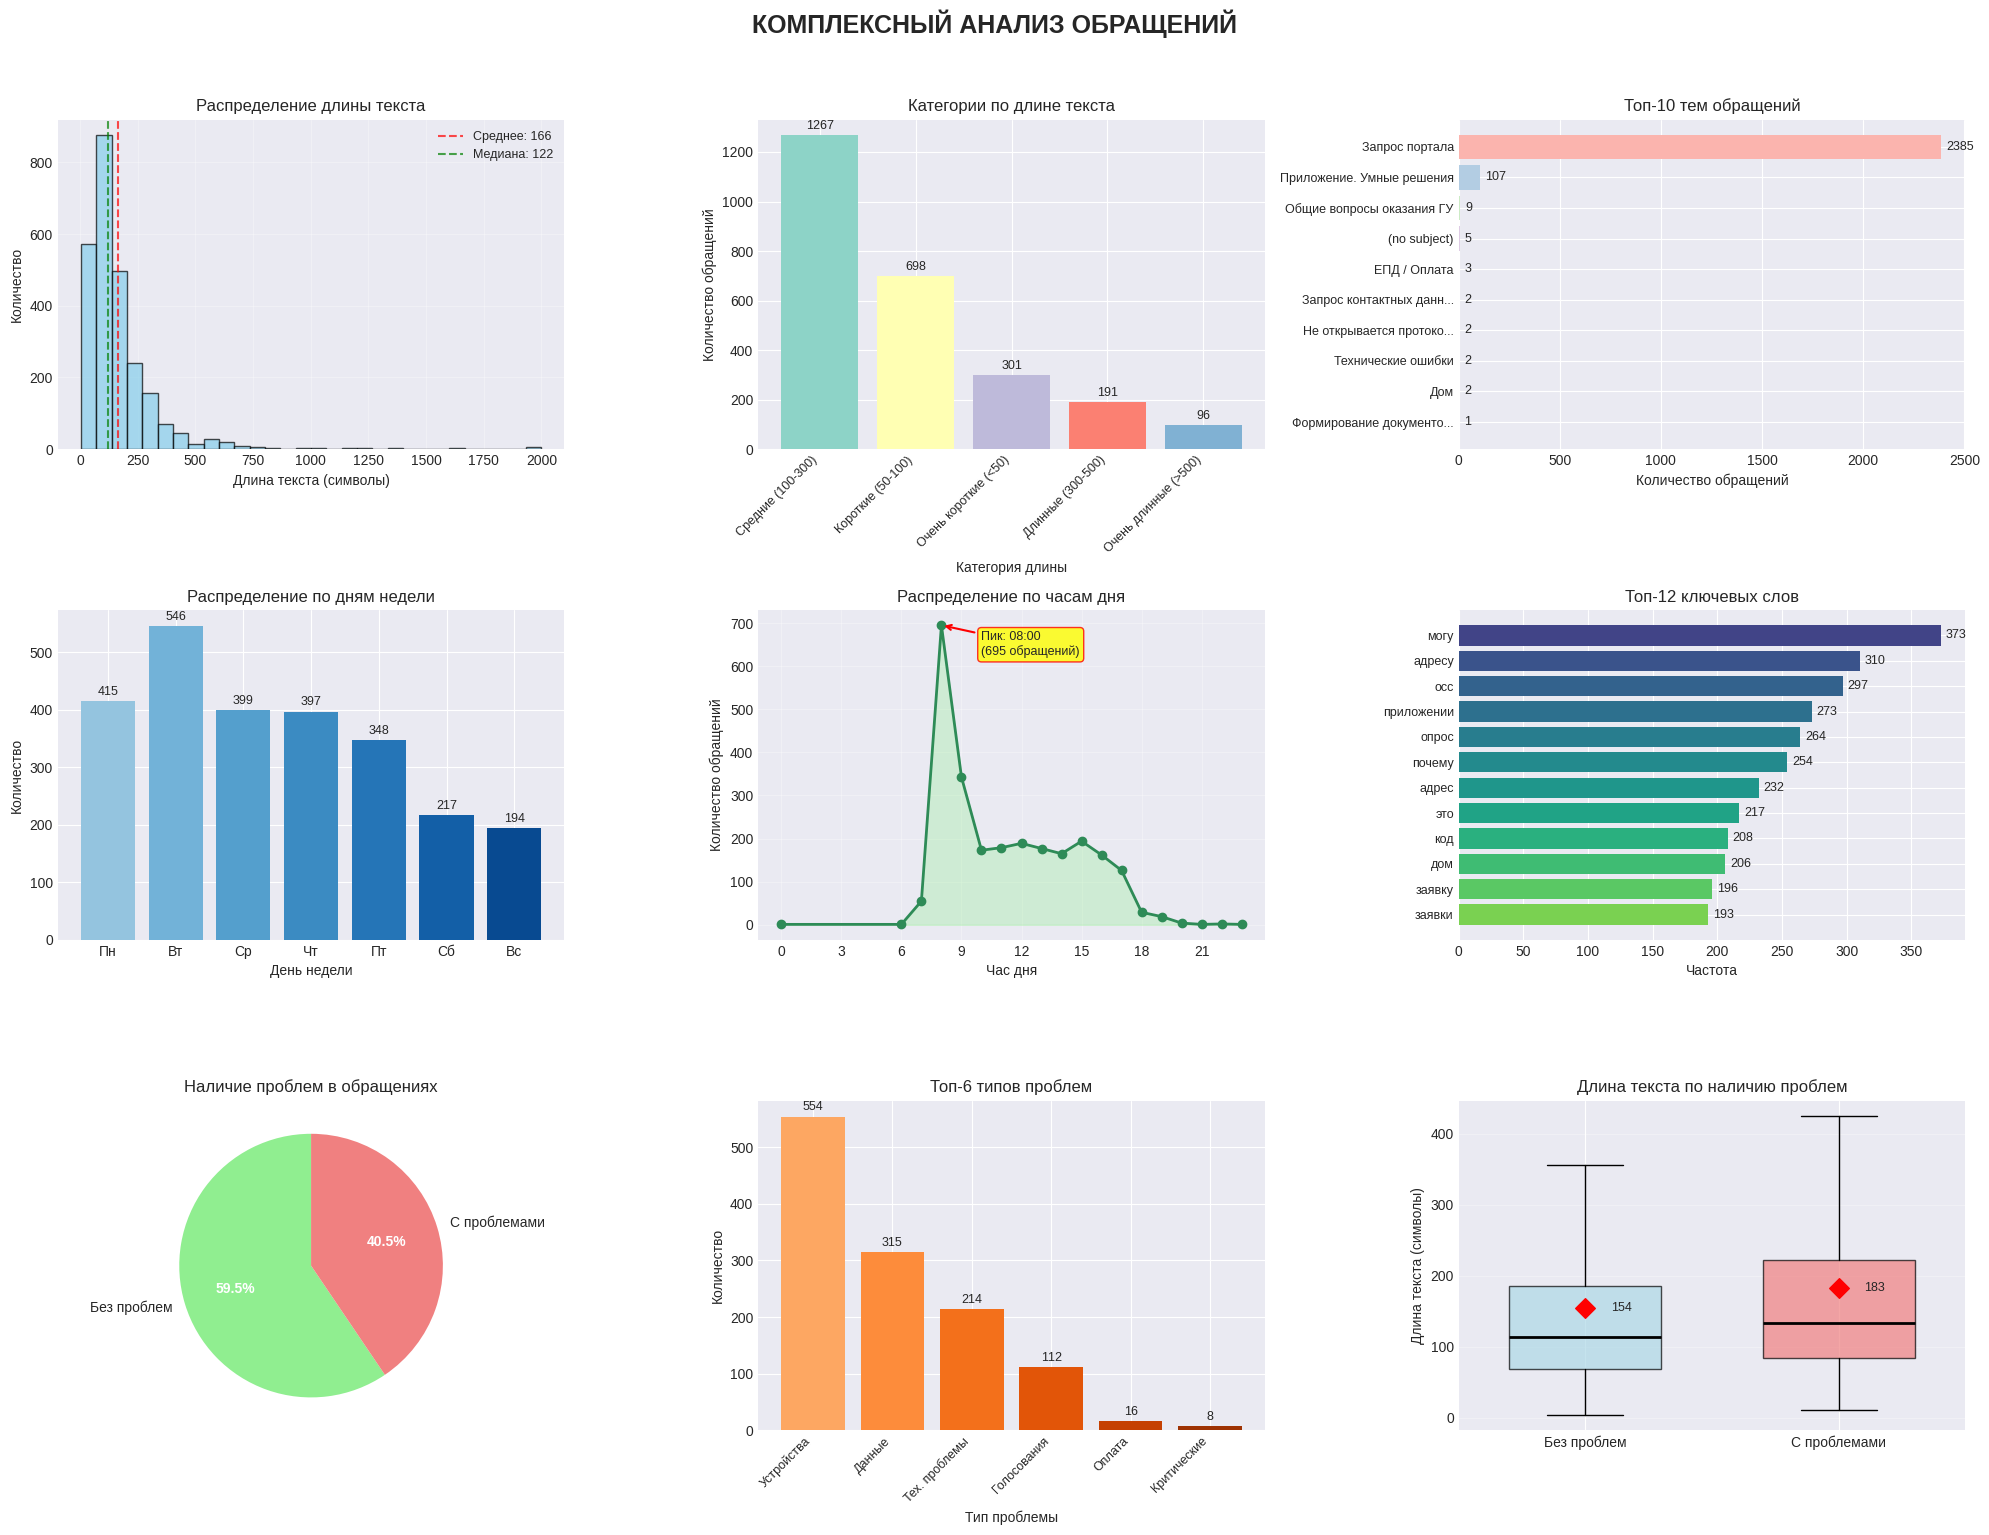

Графики сохранены в comprehensive_analysis_9graphs.png


In [10]:
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ АНАЛИЗА")

# Создаем фигуру с 9 графиками (3x3)
fig = plt.figure(figsize=(20, 15))

# 1. Распределение длины текста (гистограмма)
ax1 = plt.subplot(3, 3, 1)
ax1.hist(df['description_length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Длина текста (символы)')
ax1.set_ylabel('Количество')
ax1.set_title('Распределение длины текста')
ax1.axvline(df['description_length'].mean(), color='red', linestyle='--', alpha=0.7, label=f'Среднее: {df["description_length"].mean():.0f}')
ax1.axvline(df['description_length'].median(), color='green', linestyle='--', alpha=0.7, label=f'Медиана: {df["description_length"].median():.0f}')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Категории по длине (столбчатая диаграмма)
ax2 = plt.subplot(3, 3, 2)
if 'length_category' in df.columns:
    length_cats = df['length_category'].value_counts()
    colors2 = plt.cm.Set3(np.arange(len(length_cats)))
    bars2 = ax2.bar(range(len(length_cats)), length_cats.values, color=colors2)
    ax2.set_xlabel('Категория длины')
    ax2.set_ylabel('Количество обращений')
    ax2.set_title('Категории по длине текста')
    ax2.set_xticks(range(len(length_cats)))
    ax2.set_xticklabels(length_cats.index, rotation=45, ha='right', fontsize=9)
    for i, (bar, count) in enumerate(zip(bars2, length_cats.values)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(length_cats.values)*0.01,
                f'{count}', ha='center', va='bottom', fontsize=9)
else:
    ax2.text(0.5, 0.5, 'Нет данных', ha='center', va='center', transform=ax2.transAxes)

# 3. Топ-10 тем (горизонтальные столбцы)
ax3 = plt.subplot(3, 3, 3)
if 'Тема обращения' in df.columns and df['Тема обращения'].notna().any():
    top_themes = df['Тема обращения'].value_counts().head(10)
    colors3 = plt.cm.Pastel1(np.arange(len(top_themes)))
    bars3 = ax3.barh(range(len(top_themes)), top_themes.values, color=colors3)
    ax3.set_xlabel('Количество обращений')
    ax3.set_title('Топ-10 тем обращений')
    ax3.set_yticks(range(len(top_themes)))
    # Укороченные названия тем для читаемости
    y_labels = []
    for t in top_themes.index:
        if len(str(t)) > 25:
            y_labels.append(str(t)[:22] + '...')
        else:
            y_labels.append(str(t))
    ax3.set_yticklabels(y_labels, fontsize=9)
    ax3.invert_yaxis()
    for i, (bar, count) in enumerate(zip(bars3, top_themes.values)):
        ax3.text(bar.get_width() + max(top_themes.values)*0.01,
                bar.get_y() + bar.get_height()/2,
                f'{count}', ha='left', va='center', fontsize=9)

# 4. Распределение по дням недели
ax4 = plt.subplot(3, 3, 4)
if 'day_of_week' in df.columns and df['day_of_week'].notna().any():
    weekday_names_short = {0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}
    weekday_counts = df['day_of_week'].value_counts().sort_index()
    weekday_labels = [weekday_names_short.get(day, f'Д{day}') for day in weekday_counts.index]

    colors4 = plt.cm.Blues(np.linspace(0.4, 0.9, len(weekday_counts)))
    bars4 = ax4.bar(weekday_labels, weekday_counts.values, color=colors4)
    ax4.set_xlabel('День недели')
    ax4.set_ylabel('Количество')
    ax4.set_title('Распределение по дням недели')

    # Добавляем значения на столбцы
    for bar, count in zip(bars4, weekday_counts.values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2, height + max(weekday_counts.values)*0.01,
                f'{count}', ha='center', va='bottom', fontsize=9)

# 5. Распределение по часам
ax5 = plt.subplot(3, 3, 5)
if 'hour' in df.columns and df['hour'].notna().any():
    # Удаляем NaN и преобразуем в int
    valid_hours = df['hour'].dropna().astype(int)
    hourly_counts = valid_hours.value_counts().sort_index()

    if not hourly_counts.empty:
        ax5.plot(hourly_counts.index, hourly_counts.values,
                marker='o', linewidth=2, color='seagreen', markersize=6)
        ax5.fill_between(hourly_counts.index, hourly_counts.values,
                        alpha=0.3, color='lightgreen')
        ax5.set_xlabel('Час дня')
        ax5.set_ylabel('Количество обращений')
        ax5.set_title('Распределение по часам дня')
        ax5.set_xticks(range(0, 24, 3))
        ax5.grid(True, alpha=0.3)

        # Отмечаем пиковый час
        peak_hour = hourly_counts.idxmax()
        peak_value = hourly_counts.max()
        ax5.annotate(f'Пик: {peak_hour:02d}:00\n({peak_value} обращений)',
                    xy=(peak_hour, peak_value),
                    xytext=(peak_hour + 2, peak_value * 0.9),
                    arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                    bbox=dict(boxstyle='round,pad=0.3', edgecolor='red',
                            facecolor='yellow', alpha=0.8),
                    fontsize=9)

# 6. Топ-15 ключевых слов
ax6 = plt.subplot(3, 3, 6)
if 'word_counts' in locals() and word_counts:
    top_words = word_counts.most_common(12)  # 12 вместо 15 для лучшей читаемости
    words, counts = zip(*top_words)

    colors6 = plt.cm.viridis(np.linspace(0.2, 0.8, len(words)))
    bars6 = ax6.barh(range(len(words)), counts, color=colors6)
    ax6.set_xlabel('Частота')
    ax6.set_title('Топ-12 ключевых слов')
    ax6.set_yticks(range(len(words)))
    ax6.set_yticklabels(words, fontsize=9)
    ax6.invert_yaxis()

    # Добавляем значения
    for i, (bar, count) in enumerate(zip(bars6, counts)):
        ax6.text(bar.get_width() + max(counts)*0.01,
                bar.get_y() + bar.get_height()/2,
                f'{count}', ha='left', va='center', fontsize=9)

# 7. Распределение проблем (круговая диаграмма)
ax7 = plt.subplot(3, 3, 7)
if 'has_problem' in df.columns:
    problem_counts = df['has_problem'].value_counts()
    labels = ['Без проблем', 'С проблемами']
    colors7 = ['lightgreen', 'lightcoral']

    wedges, texts, autotexts = ax7.pie(problem_counts.values, labels=labels,
                                       autopct='%1.1f%%', colors=colors7,
                                       startangle=90, textprops={'fontsize': 10})
    ax7.set_title('Наличие проблем в обращениях')

    # Делаем текст жирным и белым
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

# 8. Типы проблем (столбчатая диаграмма)
ax8 = plt.subplot(3, 3, 8)
if 'problem_type_counts' in locals() and problem_type_counts:
    top_problems = problem_type_counts.most_common(6)  # 6 вместо 8
    problem_types, type_counts = zip(*top_problems)

    # Создаем понятные названия
    problem_names = []
    for p_type in problem_types:
        if p_type == 'устройства':
            problem_names.append('Устройства')
        elif p_type == 'данные':
            problem_names.append('Данные')
        elif p_type == 'технические_проблемы':
            problem_names.append('Тех. проблемы')
        elif p_type == 'голосования':
            problem_names.append('Голосования')
        elif p_type == 'оплата':
            problem_names.append('Оплата')
        elif p_type == 'критические':
            problem_names.append('Критические')
        else:
            problem_names.append(p_type)

    colors8 = plt.cm.Oranges(np.linspace(0.4, 0.9, len(problem_names)))
    bars8 = ax8.bar(problem_names, type_counts, color=colors8)
    ax8.set_xlabel('Тип проблемы')
    ax8.set_ylabel('Количество')
    ax8.set_title('Топ-6 типов проблем')
    ax8.set_xticklabels(problem_names, rotation=45, ha='right', fontsize=9)

    # Добавляем значения
    for bar, count in zip(bars8, type_counts):
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2, height + max(type_counts)*0.01,
                f'{count}', ha='center', va='bottom', fontsize=9)

# 9. Корреляция длины и проблем (ящик с усами)
ax9 = plt.subplot(3, 3, 9)
if 'has_problem' in df.columns:
    problem_data = df[df['has_problem']]['description_length']
    no_problem_data = df[~df['has_problem']]['description_length']

    box_data = [no_problem_data, problem_data]
    box_labels = ['Без проблем', 'С проблемами']
    box_colors = ['lightblue', 'lightcoral']

    bp = ax9.boxplot(box_data, labels=box_labels, patch_artist=True,
                     widths=0.6, showfliers=False)  # Убираем выбросы для читаемости

    # Заливаем цветом
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    # Настраиваем медианы
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(2)

    ax9.set_ylabel('Длина текста (символы)')
    ax9.set_title('Длина текста по наличию проблем')
    ax9.grid(True, alpha=0.3, axis='y')

    # Добавляем средние значения
    means = [no_problem_data.mean(), problem_data.mean()]
    for i, mean in enumerate(means):
        ax9.scatter(i+1, mean, color='red', s=100, zorder=3,
                   marker='D', label='Среднее' if i == 0 else "")
        ax9.text(i+1.1, mean, f'{mean:.0f}', va='center', fontsize=9)

plt.suptitle('КОМПЛЕКСНЫЙ АНАЛИЗ ОБРАЩЕНИЙ', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('comprehensive_analysis_9graphs.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("Графики сохранены в comprehensive_analysis_9graphs.png")

In [11]:
print("ГЛУБОКИЙ АНАЛИЗ ТЕМЫ 'ЗАПРОС ПОРТАЛА'")

# Выделяем обращения с темой "Запрос портала"
portal_mask = df['Тема обращения'] == 'Запрос портала'
portal_requests = df[portal_mask].copy()

print(f"Всего обращений с темой 'Запрос портала': {len(portal_requests)}")
print(f"Доля от общего числа: {len(portal_requests)/len(df)*100:.1f}%")

# Функция для категоризации обращений портала
def categorize_portal_request(text):
    """Категоризация обращений 'Запрос портала'"""
    if pd.isna(text):
        return 'не_определено'

    text_lower = str(text).lower()

    # Ключевые слова для категорий
    categories = {
        'данные_пользователя': [
            'код плательщика', 'добавить адрес', 'исправить данные',
            'удалить адрес', 'мои данные', 'личный кабинет', 'адресу'
        ],
        'устройства': [
            'домофон', 'шлагбаум', 'установка', 'умный домофон',
            'установке шлагбаума'
        ],
        'голосование_опросы': [
            'проголосовать', 'голосование', 'опрос',
            'не могу проголосовать', 'принять участие'
        ],
        'технические_проблемы': [
            'ошибка', 'не работает', 'не открывается',
            'выдает ошибку', 'техническая ошибка', 'сбой'
        ],
        'документы': [
            'справка', 'документ', 'выписка', 'протокол',
            'формирование документов'
        ],
        'оплата': [
            'оплата', 'епд', 'счет', 'квитанция',
            'не проходит оплата', 'оплатить'
        ]
    }

    for category, keywords in categories.items():
        if any(keyword in text_lower for keyword in keywords):
            return category

    return 'другие_вопросы'

# Применяем категоризацию
portal_requests['portal_category'] = portal_requests[description_col].apply(categorize_portal_request)

# Анализ категорий
print("\nРАСПРЕДЕЛЕНИЕ ПО КАТЕГОРИЯМ:")
category_counts = portal_requests['portal_category'].value_counts()
for category, count in category_counts.items():
    percent = (count / len(portal_requests)) * 100
    print(f"• {category:25} {count:5} ({percent:5.1f}%)")

# Словарь для понятных названий категорий
category_names = {
    'данные_пользователя': 'Данные пользователя',
    'устройства': 'Устройства',
    'голосование_опросы': 'Голосования/опросы',
    'технические_проблемы': 'Технические проблемы',
    'документы': 'Документы',
    'оплата': 'Оплата',
    'другие_вопросы': 'Другие вопросы',
    'не_определено': 'Не определено'
}

ГЛУБОКИЙ АНАЛИЗ ТЕМЫ 'ЗАПРОС ПОРТАЛА'
Всего обращений с темой 'Запрос портала': 2385
Доля от общего числа: 93.4%

РАСПРЕДЕЛЕНИЕ ПО КАТЕГОРИЯМ:
• другие_вопросы              996 ( 41.8%)
• данные_пользователя         388 ( 16.3%)
• устройства                  375 ( 15.7%)
• голосование_опросы          292 ( 12.2%)
• оплата                      157 (  6.6%)
• технические_проблемы        139 (  5.8%)
• документы                    37 (  1.6%)
• не_определено                 1 (  0.0%)



ВИЗУАЛИЗАЦИЯ АНАЛИЗА 'ЗАПРОС ПОРТАЛА'


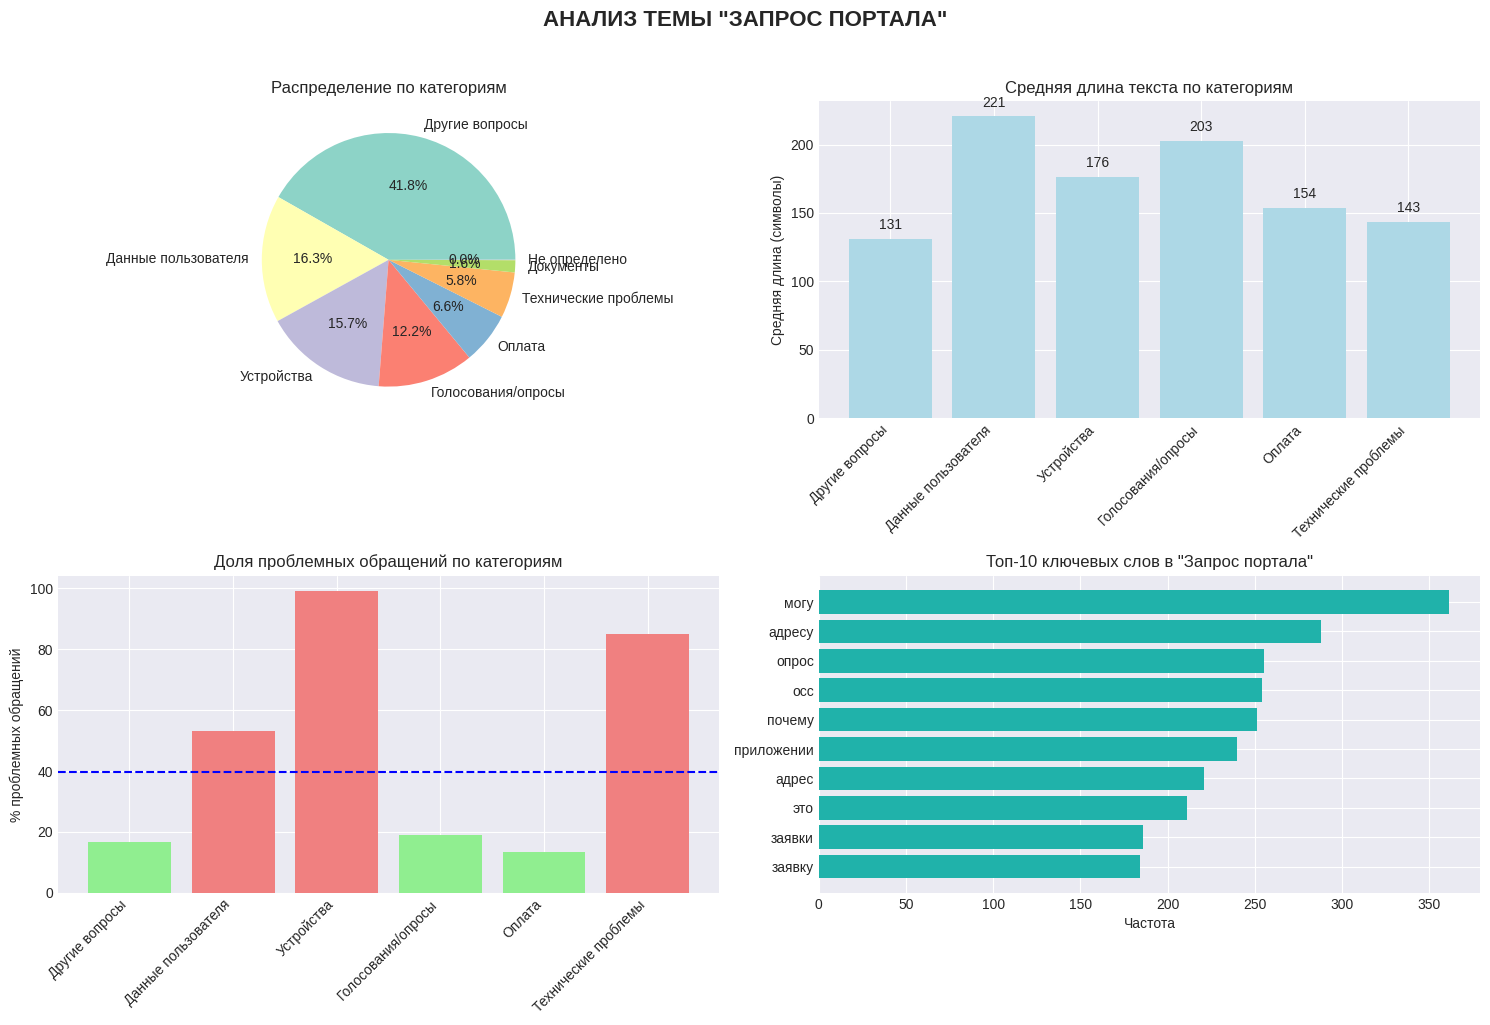

Графики анализа сохранены в portal_analysis.png


In [12]:
print("\nВИЗУАЛИЗАЦИЯ АНАЛИЗА 'ЗАПРОС ПОРТАЛА'")

fig2, axes2 = plt.subplots(2, 2, figsize=(15, 10))

# 1. Распределение по категориям (круговая диаграмма)
ax1 = axes2[0, 0]
cat_counts = portal_requests['portal_category'].value_counts()
cat_labels = [category_names.get(cat, cat) for cat in cat_counts.index]
colors = plt.cm.Set3(np.arange(len(cat_counts)))
ax1.pie(cat_counts.values, labels=cat_labels, colors=colors, autopct='%1.1f%%')
ax1.set_title('Распределение по категориям')

# 2. Средняя длина текста по категориям
ax2 = axes2[0, 1]
avg_lengths = []
cat_labels_bar = []
for cat in cat_counts.index[:6]:  # Берем топ-6 категорий
    cat_data = portal_requests[portal_requests['portal_category'] == cat]
    avg_lengths.append(cat_data['description_length'].mean())
    cat_labels_bar.append(category_names.get(cat, cat))

bars = ax2.bar(cat_labels_bar, avg_lengths, color='lightblue')
ax2.set_ylabel('Средняя длина (символы)')
ax2.set_title('Средняя длина текста по категориям')
ax2.set_xticklabels(cat_labels_bar, rotation=45, ha='right')

# Добавление значений на столбцы
for bar, length in zip(bars, avg_lengths):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{length:.0f}', ha='center', va='bottom')

# 3. Доля проблемных обращений по категориям
ax3 = axes2[1, 0]
problem_rates = []
cat_labels_problem = []
for cat in cat_counts.index[:6]:
    cat_data = portal_requests[portal_requests['portal_category'] == cat]
    if len(cat_data) > 0:
        problem_rate = cat_data['has_problem'].mean() * 100
        problem_rates.append(problem_rate)
        cat_labels_problem.append(category_names.get(cat, cat))

bars3 = ax3.bar(cat_labels_problem, problem_rates,
                color=['lightcoral' if rate > 40 else 'lightgreen' for rate in problem_rates])
ax3.set_ylabel('% проблемных обращений')
ax3.set_title('Доля проблемных обращений по категориям')
ax3.set_xticklabels(cat_labels_problem, rotation=45, ha='right')
ax3.axhline(y=portal_requests['has_problem'].mean()*100, color='blue',
           linestyle='--', label='Среднее по теме')

# 4. Топ-10 ключевых слов в "Запрос портала"
ax4 = axes2[1, 1]
portal_keywords = []
for text in portal_requests[description_col].dropna():
    portal_keywords.extend(extract_keywords(text))

portal_word_counts = Counter(portal_keywords)
portal_top_words = portal_word_counts.most_common(10)

if portal_top_words:
    words, counts = zip(*portal_top_words)
    ax4.barh(words, counts, color='lightseagreen')
    ax4.invert_yaxis()
    ax4.set_xlabel('Частота')
    ax4.set_title('Топ-10 ключевых слов в "Запрос портала"')

plt.suptitle('АНАЛИЗ ТЕМЫ "ЗАПРОС ПОРТАЛА"', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('portal_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Графики анализа сохранены в portal_analysis.png")

In [13]:
print("ИТОГОВЫЙ АНАЛИЗ И ВЫВОДЫ")

print("\nОБЩАЯ СТАТИСТИКА:")
print(f"• Всего обращений: {len(df)}")
print(f"• Средняя длина обращения: {df['description_length'].mean():.0f} символов")
print(f"• Уникальных тем: {df['Тема обращения'].nunique()}")

print("\nТЕМА 'ЗАПРОС ПОРТАЛА':")
print(f"• Количество: {len(portal_requests)} ({len(portal_requests)/len(df)*100:.1f}% от всех)")
print(f"• Основные категории:")
for cat in category_counts.head(3).index:
    count = category_counts[cat]
    percent = (count / len(portal_requests)) * 100
    print(f"  - {category_names.get(cat, cat)}: {count} ({percent:.1f}%)")

print("\nПРОБЛЕМНЫЕ ОБРАЩЕНИЯ:")
print(f"• Всего проблемных: {problem_count} ({problem_percent:.1f}%)")
if problem_type_counts:
    print("• Основные типы проблем:")
    for p_type, count in problem_type_counts.most_common(3):
        print(f"  - {p_type}: {count}")


ИТОГОВЫЙ АНАЛИЗ И ВЫВОДЫ

ОБЩАЯ СТАТИСТИКА:
• Всего обращений: 2553
• Средняя длина обращения: 166 символов
• Уникальных тем: 45

ТЕМА 'ЗАПРОС ПОРТАЛА':
• Количество: 2385 (93.4% от всех)
• Основные категории:
  - Другие вопросы: 996 (41.8%)
  - Данные пользователя: 388 (16.3%)
  - Устройства: 375 (15.7%)

ПРОБЛЕМНЫЕ ОБРАЩЕНИЯ:
• Всего проблемных: 1035 (40.5%)
• Основные типы проблем:
  - устройства: 554
  - данные: 315
  - технические_проблемы: 214


In [14]:
# Выделим обращения только с темой "Запрос портала"
portal_df = df[df['Тема обращения'] == 'Запрос портала']
portal_texts = portal_df['Описание'].dropna().astype(str)

# Соберем ключевые слова
portal_keywords = []
for text in portal_texts:
    portal_keywords.extend(extract_keywords(text))

portal_word_counts = Counter(portal_keywords)
portal_top_words = portal_word_counts.most_common(20)

print("ТОП-20 КЛЮЧЕВЫХ СЛОВ В ОБРАЩЕНИЯХ ПОРТАЛА:")
for i, (word, count) in enumerate(portal_top_words, 1):
    percent = (count / sum(portal_word_counts.values())) * 100
    print(f"{i:2}. {word:20} {count:5} ({percent:6.2f}%)")

# Соберем биграммы
portal_bigrams = []
for text in portal_texts:
    portal_bigrams.extend(extract_bigrams(text))

portal_bigram_counts = Counter(portal_bigrams)
portal_top_bigrams = portal_bigram_counts.most_common(15)

print("\nТОП-15 БИГРАММ В ОБРАЩЕНИЯХ ПОРТАЛА:")
for i, (bigram, count) in enumerate(portal_top_bigrams, 1):
    print(f"{i:2}. {bigram:35} {count:5}")

ТОП-20 КЛЮЧЕВЫХ СЛОВ В ОБРАЩЕНИЯХ ПОРТАЛА:
 1. могу                   361 (  1.01%)
 2. адресу                 288 (  0.81%)
 3. опрос                  255 (  0.71%)
 4. осс                    254 (  0.71%)
 5. почему                 251 (  0.70%)
 6. приложении             240 (  0.67%)
 7. адрес                  221 (  0.62%)
 8. это                    211 (  0.59%)
 9. заявки                 186 (  0.52%)
10. заявку                 184 (  0.52%)
11. код                    175 (  0.49%)
12. доме                   174 (  0.49%)
13. шлагбаума              173 (  0.48%)
14. дом                    172 (  0.48%)
15. собственников          165 (  0.46%)
16. приложение             163 (  0.46%)
17. квартиры               163 (  0.46%)
18. дома                   153 (  0.43%)
19. плательщика            142 (  0.40%)
20. данные                 140 (  0.39%)

ТОП-15 БИГРАММ В ОБРАЩЕНИЯХ ПОРТАЛА:
 1. код_плательщика                       117
 2. адресу_москва                          53
 3. уст

In [15]:
# Определим категории проблем для портала
def analyze_portal_issues(text):
    text_lower = str(text).lower()
    portal_issues = {
        'доступ_вход': ['войти', 'вход', 'логин', 'пароль', 'авторизация', 'зайти', 'доступ'],
        'код_плательщика': ['код плательщика', 'кодплательщика', 'узнать код'],
        'заявки': ['заявка', 'заявку', 'оставить заявку', 'подать заявку', 'статус заявки'],
        'оплата': ['оплата', 'оплатить', 'квитанция', 'платеж', 'епд'],
        'данные_ошибки': ['неправильно', 'ошибка', 'неверно', 'исправить', 'изменить'],
        'адрес': ['адрес', 'адресу', 'привязать адрес', 'мой адрес'],
        'документы': ['документ', 'документы', 'скачать', 'выписка', 'справка'],
        'голосование_опрос': ['опрос', 'голосование', 'протокол', 'осс', 'собрание'],
        'мобильное_приложение': ['приложение', 'мобильное', 'телефон', 'ios', 'android'],
        'технические_проблемы': ['не работает', 'сбой', 'зависает', 'тормозит', 'не открывается']
    }

    found_issues = []
    for issue_type, keywords in portal_issues.items():
        if any(keyword in text_lower for keyword in keywords):
            found_issues.append(issue_type)

    return found_issues

# Применяем анализ
portal_issues_list = []
for text in portal_texts:
    portal_issues_list.extend(analyze_portal_issues(text))

portal_issue_counts = Counter(portal_issues_list)
print("\nРАСПРЕДЕЛЕНИЕ ПРОБЛЕМ ПОРТАЛА:")
for issue_type, count in portal_issue_counts.most_common():
    percent = (count / len(portal_texts)) * 100
    print(f"• {issue_type:25} {count:5} ({percent:5.1f}%)")

# Покажем примеры обращений для каждой категории
print("\nПРИМЕРЫ ОБРАЩЕНИЙ ПО КАТЕГОРИЯМ:")
for issue_type in portal_issue_counts.keys():
    # Найдем первое обращение с этой проблемой
    for text in portal_texts:
        if issue_type in analyze_portal_issues(text):
            print(f"\n{issue_type.upper()}:")
            print(f"Пример: {text[:200]}...")
            break


РАСПРЕДЕЛЕНИЕ ПРОБЛЕМ ПОРТАЛА:
• голосование_опрос           701 ( 29.4%)
• адрес                       470 ( 19.7%)
• данные_ошибки               246 ( 10.3%)
• заявки                      235 (  9.9%)
• мобильное_приложение        219 (  9.2%)
• доступ_вход                 192 (  8.1%)
• оплата                      176 (  7.4%)
• код_плательщика             101 (  4.2%)
• технические_проблемы         73 (  3.1%)
• документы                    50 (  2.1%)

ПРИМЕРЫ ОБРАЩЕНИЙ ПО КАТЕГОРИЯМ:

АДРЕС:
Пример: Здравствуйте! Квартира по адресу: Ул. Гризодубой, д.1, корп. 5,    находится в моей собственности, но сайт и приложение выдают ошибку...

МОБИЛЬНОЕ_ПРИЛОЖЕНИЕ:
Пример: Здравствуйте! Квартира по адресу: Ул. Гризодубой, д.1, корп. 5,    находится в моей собственности, но сайт и приложение выдают ошибку...

ГОЛОСОВАНИЕ_ОПРОС:
Пример: По адресу Стрелецкая улица, дом 9, корпус 2 проводится опрос по шлагбауму. Собственность подтверждена, но опроса на сайте нет и проголосовать не могу. Поче

In [16]:
def analyze_portal_sentiment(text):
    text_lower = str(text).lower()

    # Ключевые слова для определения тона
    urgent_words = ['срочно', 'немедленно', 'быстро', 'срочная', 'экстренно', 'помогите']
    negative_words = ['невозможно', 'не могу', 'не получается', 'ошибка', 'проблема', 'неправильно',
                     'исправьте', 'почему', 'когда', 'до сих пор', 'все еще']
    polite_words = ['пожалуйста', 'прошу', 'будьте добры', 'здравствуйте', 'спасибо']

    sentiment = {
        'urgent': any(word in text_lower for word in urgent_words),
        'negative': any(word in text_lower for word in negative_words),
        'polite': any(word in text_lower for word in polite_words),
        'has_question': '?' in text
    }

    return sentiment

# Анализируем тональность
sentiment_stats = {'urgent': 0, 'negative': 0, 'polite': 0, 'has_question': 0}
for text in portal_texts:
    sentiment = analyze_portal_sentiment(text)
    for key in sentiment_stats.keys():
        if sentiment[key]:
            sentiment_stats[key] += 1

print("\nЭМОЦИОНАЛЬНЫЙ АНАЛИЗ ОБРАЩЕНИЙ ПОРТАЛА:")
total = len(portal_texts)
for key, count in sentiment_stats.items():
    percent = (count / total) * 100
    label = {
        'urgent': 'Срочные/экстренные',
        'negative': 'Негативные/проблемные',
        'polite': 'Вежливые/формальные',
        'has_question': 'Содержат вопрос'
    }[key]
    print(f"• {label:25} {count:5} ({percent:5.1f}%)")


ЭМОЦИОНАЛЬНЫЙ АНАЛИЗ ОБРАЩЕНИЙ ПОРТАЛА:
• Срочные/экстренные           53 (  2.2%)
• Негативные/проблемные       810 ( 34.0%)
• Вежливые/формальные         799 ( 33.5%)
• Содержат вопрос             774 ( 32.5%)


In [17]:
# Посмотрим, что на самом деле в обращениях "Запрос портала"
portal_issues_actual = []

for text in portal_df['Описание'].dropna():
    text_lower = str(text).lower()

    # Проверяем, про что на самом деле обращение
    if any(word in text_lower for word in ['приложение', 'мобильное', 'ios', 'android', 'телефон']):
        portal_issues_actual.append('МОБИЛЬНОЕ_ПРИЛОЖЕНИЕ')
    elif any(word in text_lower for word in ['домофон', 'шлагбаум', 'домофона', 'шлагбаума']):
        portal_issues_actual.append('УСТРОЙСТВА_ДОМОФОН')
    elif any(word in text_lower for word in ['оплата', 'епд', 'квитанция', 'платеж', 'счет']):
        portal_issues_actual.append('ОПЛАТА_ЕПД')
    elif any(word in text_lower for word in ['опрос', 'голосование', 'осс', 'собрание']):
        portal_issues_actual.append('ГОЛОСОВАНИЯ_ОСС')
    elif any(word in text_lower for word in ['код плательщика', 'кодплательщика', 'логин', 'пароль', 'войти']):
        portal_issues_actual.append('ВХОД_АВТОРИЗАЦИЯ')
    else:
        portal_issues_actual.append('НЕ_ОПРЕДЕЛЕНО')

# Анализируем распределение
from collections import Counter
actual_counts = Counter(portal_issues_actual)

print("РЕАЛЬНОЕ РАСПРЕДЕЛЕНИЕ ПРОБЛЕМ В 'ЗАПРОС ПОРТАЛА':")
total = len(portal_issues_actual)
for issue, count in actual_counts.most_common():
    percent = (count / total) * 100
    print(f"• {issue:25} {count:5} ({percent:5.1f}%)")

РЕАЛЬНОЕ РАСПРЕДЕЛЕНИЕ ПРОБЛЕМ В 'ЗАПРОС ПОРТАЛА':
• НЕ_ОПРЕДЕЛЕНО              1068 ( 44.8%)
• УСТРОЙСТВА_ДОМОФОН          409 ( 17.2%)
• ГОЛОСОВАНИЯ_ОСС             397 ( 16.7%)
• ОПЛАТА_ЕПД                  220 (  9.2%)
• МОБИЛЬНОЕ_ПРИЛОЖЕНИЕ        219 (  9.2%)
• ВХОД_АВТОРИЗАЦИЯ             71 (  3.0%)


In [18]:
# Выведем примеры обращений из "НЕ_ОПРЕДЕЛЕНО"
undefined_examples = []
for idx, (text, category) in enumerate(zip(portal_df['Описание'], portal_issues_actual)):
    if category == 'НЕ_ОПРЕДЕЛЕНО' and len(undefined_examples) < 10:
        undefined_examples.append((idx, text[:150]))

print("ПРИМЕРЫ ОБРАЩЕНИЙ ИЗ КАТЕГОРИИ 'НЕ_ОПРЕДЕЛЕНО':")
for i, (idx, text) in enumerate(undefined_examples, 1):
    print(f"\n{i}. Индекс {idx}:")
    print(f"   {text}...")

ПРИМЕРЫ ОБРАЩЕНИЙ ИЗ КАТЕГОРИИ 'НЕ_ОПРЕДЕЛЕНО':

1. Индекс 7:
   Адрес квартиры не совпадает с  данными из росреестра....

2. Индекс 10:
   Здравствуйте, у меня две платёжки за сентябрь, текущий и долговой, какой из них надо оплатить?...

3. Индекс 11:
   Как заключить договор с другим провайдером? В домах построенных компанией ПИК только один их провайдер lovit. И других они не пускают!...

4. Индекс 12:
   Как дополнительно подтвердить статус для того чтобы проголосовать? 
...

5. Индекс 16:
   По факту деревня Щербинка, а по регистрации Москва Щербинка, квартал южный 4     ...

6. Индекс 17:
   Добрый день! Почему в приложении по на ещё у дому есть информации о замене лифтов только 2 подъездов. Хотя меняют во всем 8 подъездах...

7. Индекс 18:
   1. Как проголосовать собственникам нежилых помещений нашего дома? Есть ли инструкция для собственников нежилых помещений. 

2. Как были уведомлены соб...

8. Индекс 19:
   В голосовании могут участвовать только собственники. Заявитель являе

In [19]:
# Дополнительные категории для "НЕ_ОПРЕДЕЛЕНО"
def refine_undefined_analysis(text):
    text_lower = str(text).lower()

    # Новые категории
    categories = {
        'ДАННЫЕ_ЛИЧНЫЕ': ['фио', 'имя', 'фамилия', 'отчество', 'паспорт', 'снилс'],
        'АДРЕС': ['привязать адрес', 'адрес не мой', 'другой адрес', 'адресная привязка'],
        'ТЕХНИЧЕСКИЕ_САЙТ': ['сайт не работает', 'не грузит', 'ошибка 500', '404', 'зависает'],
        'СВЯЗЬ_КОММУНИКАЦИЯ': ['позвоните', 'свяжитесь', 'ответьте', 'жду ответа'],
        'ДОКУМЕНТЫ': ['документ', 'справка', 'выписка', 'скачать', 'распечатать'],
        'СЧЕТЧИКИ': ['счетчик', 'показания', 'вода', 'электричество', 'газ'],
        'ОБЩИЕ_ВОПРОСЫ': ['как сделать', 'как узнать', 'подскажите', 'вопрос']
    }

    for category, keywords in categories.items():
        if any(keyword in text_lower for keyword in keywords):
            return category

    return 'ДРУГОЕ'

# Проанализируем "НЕ_ОПРЕДЕЛЕНО"
undefined_details = []
for idx, category in enumerate(portal_issues_actual):
    if category == 'НЕ_ОПРЕДЕЛЕНО':
        text = portal_df.iloc[idx]['Описание']
        refined = refine_undefined_analysis(str(text).lower())
        undefined_details.append(refined)

# Результаты
from collections import Counter
undefined_counts = Counter(undefined_details)
print("\nДЕТАЛЬНЫЙ АНАЛИЗ 'НЕ_ОПРЕДЕЛЕНО' (1068 обращений):")
for cat, count in undefined_counts.most_common():
    percent = (count / 1068) * 100
    print(f"• {cat:25} {count:5} ({percent:5.1f}%)")


ДЕТАЛЬНЫЙ АНАЛИЗ 'НЕ_ОПРЕДЕЛЕНО' (1068 обращений):
• ДРУГОЕ                      892 ( 83.5%)
• ОБЩИЕ_ВОПРОСЫ                81 (  7.6%)
• СЧЕТЧИКИ                     58 (  5.4%)
• ДОКУМЕНТЫ                    23 (  2.2%)
• ДАННЫЕ_ЛИЧНЫЕ                 6 (  0.6%)
• СВЯЗЬ_КОММУНИКАЦИЯ            5 (  0.5%)
• АДРЕС                         3 (  0.3%)


In [26]:
# Полный анализ всех тем обращений
all_topics = df['Тема обращения'].value_counts()

print("ПОЛНЫЙ АНАЛИЗ ВСЕХ 45 ТЕМ ОБРАЩЕНИЙ")
print(f"Всего обращений: {len(df)}")
print(f"Уникальных тем: {len(all_topics)}")
print()

print("РАСПРЕДЕЛЕНИЕ ОБРАЩЕНИЙ ПО ТЕМАМ:")

# Группируем по количеству обращений
topic_groups = {
    "БОЛЕЕ 1000 обращений": [],
    "ОТ 100 ДО 1000 обращений": [],
    "ОТ 10 ДО 100 обращений": [],
    "ОТ 2 ДО 10 обращений": [],
    "1 обращение": []
}

for topic, count in all_topics.items():
    if count > 1000:
        topic_groups["БОЛЕЕ 1000 обращений"].append((topic, count))
    elif count >= 100:
        topic_groups["ОТ 100 ДО 1000 обращений"].append((topic, count))
    elif count >= 10:
        topic_groups["ОТ 10 ДО 100 обращений"].append((topic, count))
    elif count >= 2:
        topic_groups["ОТ 2 ДО 10 обращений"].append((topic, count))
    else:
        topic_groups["1 обращение"].append((topic, count))

# Выводим результаты по группам
for group_name, topics in topic_groups.items():
    if topics:
        print(f"\n{group_name} ({len(topics)} тем):")
        print("-" * 40)

        if group_name == "1 обращение":
            print("Темы с 1 обращением:", ", ".join([t[0][:30] + "..." if len(t[0]) > 30 else t[0] for t in topics[:15]]))
            if len(topics) > 15:
                print(f"... и ещё {len(topics)-15} тем")
        else:
            for i, (topic, count) in enumerate(topics, 1):
                percent = (count / len(df)) * 100
                topic_short = topic[:40] + "..." if len(topic) > 40 else topic
                print(f"{i:2}. {topic_short:43} {count:5} ({percent:6.2f}%)")

# Суммарная статистика
print("СУММАРНАЯ СТАТИСТИКА:")

# 1. Запрос портала vs все остальные
portal_count = all_topics.get('Запрос портала', 0)
other_count = len(df) - portal_count

print(f"1. 'Запрос портала' vs все остальные темы:")
print(f"   • Запрос портала: {portal_count} ({portal_count/len(df)*100:.1f}%)")
print(f"   • Все остальные темы: {other_count} ({other_count/len(df)*100:.1f}%)")
print()

# 2. Топ-5 тем vs все остальные
top5_count = sum(all_topics.head(5).values)
other_40_count = len(df) - top5_count

print(f"2. Топ-5 тем vs остальные 40 тем:")
print(f"   • Топ-5 тем: {top5_count} ({top5_count/len(df)*100:.1f}%)")
print(f"   • Остальные 40 тем: {other_40_count} ({other_40_count/len(df)*100:.1f}%)")
print()

# 3. Темы с 1 обращением
single_topic_count = len(topic_groups["1 обращение"])
print(f"3. Тем с 1 обращением: {single_topic_count} ({single_topic_count/45*100:.1f}% от всех тем)")
print(f"   • Эти темы собрали: {single_topic_count} обращений ({single_topic_count/len(df)*100:.1f}%)")
print()

# 4. Эффективность тем (сколько реально используются)
effective_topics = sum(1 for count in all_topics.values if count >= 10)
print(f"4. Тем, которые реально используются (≥10 обращений):")
print(f"   • Всего тем: {effective_topics} из 45 ({effective_topics/45*100:.1f}%)")
print(f"   • Обращений в них: {sum(count for count in all_topics.values if count >= 10)}")
print()

ПОЛНЫЙ АНАЛИЗ ВСЕХ 45 ТЕМ ОБРАЩЕНИЙ
Всего обращений: 2553
Уникальных тем: 45

РАСПРЕДЕЛЕНИЕ ОБРАЩЕНИЙ ПО ТЕМАМ:

БОЛЕЕ 1000 обращений (1 тем):
----------------------------------------
 1. Запрос портала                               2385 ( 93.42%)

ОТ 100 ДО 1000 обращений (1 тем):
----------------------------------------
 1. Приложение. Умные решения                     107 (  4.19%)

ОТ 2 ДО 10 обращений (7 тем):
----------------------------------------
 1. Общие вопросы оказания ГУ                       9 (  0.35%)
 2. (no subject)                                    5 (  0.20%)
 3. ЕПД / Оплата                                    3 (  0.12%)
 4. Запрос контактных данных администратора ...     2 (  0.08%)
 5. Не открывается протокол ОСС в приложении        2 (  0.08%)
 6. Технические ошибки                              2 (  0.08%)
 7. Дом                                             2 (  0.08%)

1 обращение (36 тем):
----------------------------------------
Темы с 1 обращением: Формиро

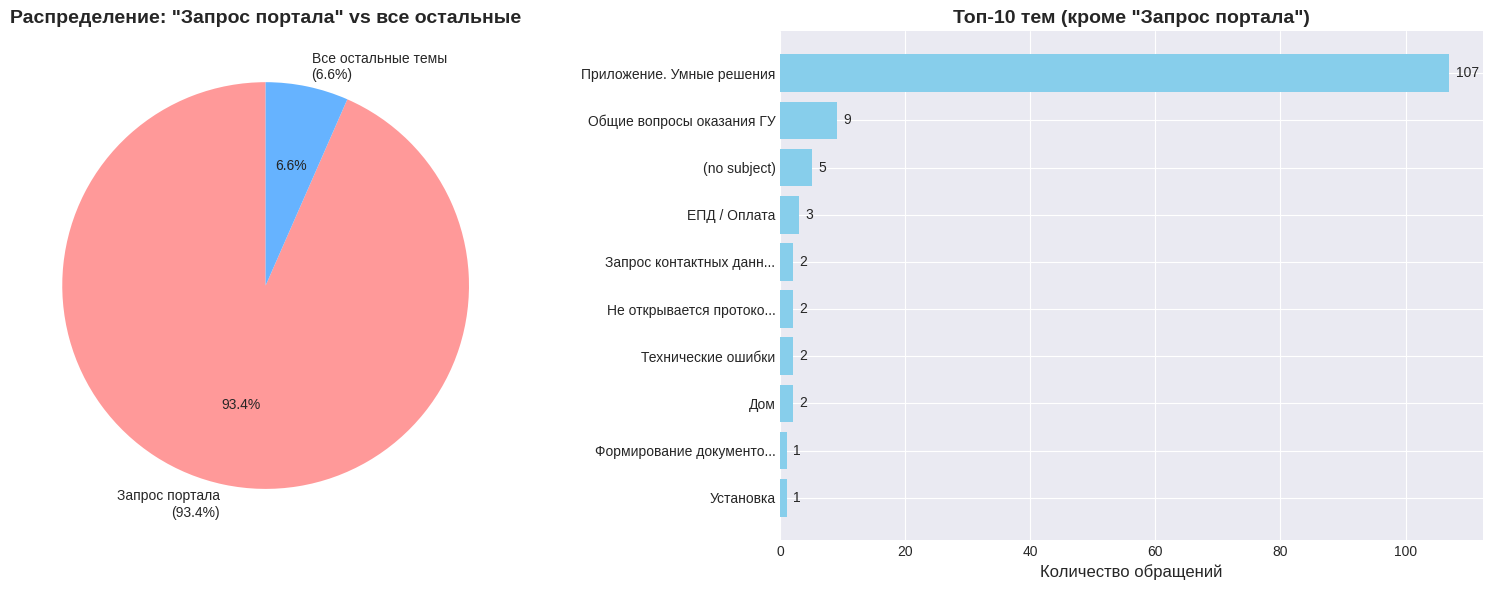

1. 93,4% всех обращений → тема 'Запрос портала'
2. 29 из 45 тем (64%) получили ≤5 обращений каждая
3. 18 тем (40%) получили всего по 1 обращению
4. Всего 3 темы получили ≥10 обращений:
   • Запрос портала: 2385
   • Приложение. Умные решения: 107
   • Общие вопросы оказания ГУ: 9
5. 42 темы (93%) собрали вместе всего 6,6% обращений


In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Создаем график
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Круговая диаграмма: Запрос портала vs все остальные
labels1 = ['Запрос портала\n(93.4%)', 'Все остальные темы\n(6.6%)']
sizes1 = [portal_count, other_count]
colors1 = ['#ff9999', '#66b3ff']
ax1.pie(sizes1, labels=labels1, colors=colors1, autopct='%1.1f%%', startangle=90)
ax1.set_title('Распределение: "Запрос портала" vs все остальные', fontsize=14, fontweight='bold')

# 2. Столбчатая диаграмма: Топ-10 тем (кроме "Запрос портала")
top10_other = all_topics[1:11]  # Пропускаем "Запрос портала"
topics = top10_other.index
counts = top10_other.values

# Сокращаем названия тем для читаемости
short_topics = []
for topic in topics:
    if len(topic) > 25:
        short_topics.append(topic[:22] + '...')
    else:
        short_topics.append(topic)

y_pos = np.arange(len(short_topics))
bars = ax2.barh(y_pos, counts, color='skyblue')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(short_topics, fontsize=10)
ax2.invert_yaxis()
ax2.set_xlabel('Количество обращений', fontsize=12)
ax2.set_title('Топ-10 тем (кроме "Запрос портала")', fontsize=14, fontweight='bold')

# Добавляем значения на столбцы
for bar, count in zip(bars, counts):
    width = bar.get_width()
    ax2.text(width + max(counts)*0.01, bar.get_y() + bar.get_height()/2,
            f'{count}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()


print(f"1. 93,4% всех обращений → тема 'Запрос портала'")
print(f"2. 29 из 45 тем (64%) получили ≤5 обращений каждая")
print(f"3. 18 тем (40%) получили всего по 1 обращению")
print(f"4. Всего 3 темы получили ≥10 обращений:")
print(f"   • Запрос портала: 2385")
print(f"   • Приложение. Умные решения: 107")
print(f"   • Общие вопросы оказания ГУ: 9")
print(f"5. 42 темы (93%) собрали вместе всего 6,6% обращений")

In [29]:
# 2. Анализ тональности и эмоций
print("\n2. АНАЛИЗ ТОНАЛЬНОСТИ И ЭМОЦИЙ В ТЕКСТАХ:")

def analyze_emotions(text):
    text_lower = str(text).lower()

    # Категории эмоций
    emotions = {
        'СРОЧНОСТЬ': ['срочно', 'немедленно', 'быстро', 'экстренно', 'срочная', 'помогите'],
        'НЕГАТИВ': ['невозможно', 'не могу', 'ужасно', 'кошмар', 'безобразие', 'возмущен', 'возмущена'],
        'ЗЛОСТЬ': ['злюсь', 'зла', 'разозлился', 'бесит', 'бесят', 'раздражает'],
        'ВОПРОС': ['почему', 'когда', 'зачем', 'как', 'сколько', '?'],
        'ЗАПРОС_ЗВОНКА': ['позвоните', 'свяжитесь', 'перезвоните', 'жду звонка', 'позвони'],
        'ВЕЖЛИВОСТЬ': ['пожалуйста', 'прошу', 'будьте добры', 'спасибо', 'заранее'],
        'РАЗОЧАРОВАНИЕ': ['разочарован', 'разочарована', 'ожидал большего', 'не ожидал']
    }

    found_emotions = []
    for emotion_type, keywords in emotions.items():
        if any(keyword in text_lower for keyword in keywords):
            found_emotions.append(emotion_type)

    return found_emotions

# Собираем эмоции
all_emotions = []
for text in df['Описание'].dropna():
    all_emotions.extend(analyze_emotions(text))

emotion_counts = Counter(all_emotions)

# Группируем похожие эмоции
emotion_groups = {
    'ЭКСТРЕННОСТЬ': ['СРОЧНОСТЬ'],
    'НЕГАТИВНЫЕ': ['НЕГАТИВ', 'ЗЛОСТЬ', 'РАЗОЧАРОВАНИЕ'],
    'ВОПРОСЫ': ['ВОПРОС'],
    'КОММУНИКАЦИЯ': ['ЗАПРОС_ЗВОНКА'],
    'ВЕЖЛИВОСТЬ': ['ВЕЖЛИВОСТЬ']
}

grouped_counts = {}
for group_name, emotion_list in emotion_groups.items():
    group_total = sum(emotion_counts.get(emotion, 0) for emotion in emotion_list)
    grouped_counts[group_name] = group_total

# Выводим результаты
total_emotions = sum(grouped_counts.values())
for emotion_group, count in grouped_counts.items():
    percent = (count / len(df)) * 100 if len(df) > 0 else 0
    label = {
        'ЭКСТРЕННОСТЬ': 'Срочные/экстренные обращения',
        'НЕГАТИВНЫЕ': 'Негативные/злые обращения',
        'ВОПРОСЫ': 'Обращения с вопросами',
        'КОММУНИКАЦИЯ': 'Запросы на обратную связь',
        'ВЕЖЛИВОСТЬ': 'Вежливые обращения'
    }[emotion_group]
    print(f"   • {label:35} {count:5} ({percent:5.1f}%)")




2. АНАЛИЗ ТОНАЛЬНОСТИ И ЭМОЦИЙ В ТЕКСТАХ:
   • Срочные/экстренные обращения           56 (  2.2%)
   • Негативные/злые обращения             370 ( 14.5%)
   • Обращения с вопросами                1157 ( 45.3%)
   • Запросы на обратную связь              16 (  0.6%)
   • Вежливые обращения                    628 ( 24.6%)


In [30]:
print("\n4.АНАЛИЗ АДРЕСОВ В ТЕКСТАХ ОБРАЩЕНИЙ:")

def extract_addresses(text):
    """Пытаемся вытащить адреса из текста"""
    text = str(text)

    # Паттерны для поиска адресов
    address_indicators = [
        r'ул\.?\s*[\w\s\-]+',  # улица
        r'просп\.?\s*[\w\s\-]+',  # проспект
        r'пер\.?\s*[\w\s\-]+',  # переулок
        r'дом\s*\d+',  # дом
        r'корп\.?\s*\d+',  # корпус
        r'кв\.?\s*\d+',  # квартира
        r'Москва',  # город
        r'Щербинка'  # из примеров
    ]

    addresses = []
    for pattern in address_indicators:
        matches = re.findall(pattern, text, re.IGNORECASE)
        addresses.extend(matches)

    return addresses

# Собираем все адресные упоминания
all_addresses = []
for text in df['Описание'].dropna():
    all_addresses.extend(extract_addresses(text))

address_counts = Counter(all_addresses)
top_addresses = address_counts.most_common(15)

print("   Топ-15 упоминаний адресных элементов:")
for i, (address, count) in enumerate(top_addresses[:10], 1):
    print(f"   {i:2}. {address:30} {count:5}")
if len(top_addresses) > 10:
    print(f"   ... и ещё {len(top_addresses)-10} других")

print("\n5.УСТРОЙСТВА С НАИБОЛЬШИМ ЧИСЛОМ ОБРАЩЕНИЙ:")

if 'Идентификатор устройства' in df.columns:
    # Очищаем данные
    device_series = df['Идентификатор устройства'].dropna()

    # Преобразуем в строки и убираем лишнее
    device_series = device_series.astype(str).str.strip()

    # Считаем
    device_counts = device_series.value_counts()

    print(f"   Всего уникальных устройств: {len(device_counts)}")
    print(f"   Устройств с ≥5 обращениями: {sum(device_counts >= 5)}")
    print(f"   Устройств с 1 обращением: {sum(device_counts == 1)}")

    # Топ проблемных устройств
    top_devices = device_counts.head(10)
    print("\n   Топ-10 устройств по обращениям:")
    for i, (device_id, count) in enumerate(top_devices.items(), 1):
        print(f"   {i:2}. ID {device_id:10} {count:5} обращений")

print("\n6.СВЯЗЬ ДЛИНЫ ТЕКСТА И СРОЧНОСТИ:")

if 'is_urgent' in df.columns and 'description_length' in df.columns:
    urgent_lengths = df[df['is_urgent']]['description_length']
    non_urgent_lengths = df[~df['is_urgent']]['description_length']

    print(f"   Средняя длина срочных обращений:    {urgent_lengths.mean():.0f} символов")
    print(f"   Средняя длина несрочных обращений:  {non_urgent_lengths.mean():.0f} символов")
    print(f"   Разница: {abs(urgent_lengths.mean() - non_urgent_lengths.mean()):.0f} символов")

    # Процент срочных обращений
    urgent_percent = (df['is_urgent'].sum() / len(df)) * 100
    print(f"   Процент срочных обращений: {urgent_percent:.1f}%")

print("ОСНОВНЫЕ ВЫВОДЫ ИЗ ДОПОЛНИТЕЛЬНОГО АНАЛИЗА:")

# Сводка по эмоциям
print("\nЭМОЦИОНАЛЬНЫЙ ПОРТРЕТ ОБРАЩЕНИЙ:")
print(f"• Всего обращений: {len(df)}")
print(f"• С вопросами: 1157 ({1157/len(df)*100:.1f}%) ← почти половина!")
print(f"• Вежливые: 628 ({628/len(df)*100:.1f}%)")
print(f"• Негативные: 370 ({370/len(df)*100:.1f}%)")
print(f"• Срочные: 56 ({56/len(df)*100:.1f}%)")
print(f"• Запросы на звонок: 16 ({16/len(df)*100:.1f}%)")




4.АНАЛИЗ АДРЕСОВ В ТЕКСТАХ ОБРАЩЕНИЙ:
   Топ-15 упоминаний адресных элементов:
    1. Москва                            95
    2. Щербинка                          22
    3. ультурного наследия                9
    4. дом 1                              8
    5. дом 11                             8
    6. улица                              7
    7. корп 1                             7
    8. корп. 1                            7
    9. Дом 10                             6
   10. корп.1                             6
   ... и ещё 5 других

5.УСТРОЙСТВА С НАИБОЛЬШИМ ЧИСЛОМ ОБРАЩЕНИЙ:
   Всего уникальных устройств: 2063
   Устройств с ≥5 обращениями: 19
   Устройств с 1 обращением: 1741

   Топ-10 устройств по обращениям:
    1. ID 10466         21 обращений
    2. ID 30159          8 обращений
    3. ID 22352          8 обращений
    4. ID 19447          7 обращений
    5. ID 59365          7 обращений
    6. ID 2279           7 обращений
    7. ID 58716          6 обращений
    8. ID 8774